In [1]:
file_name = "graph_path_planning.ipynb"
import sys
import os
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname(file_name), '../../src/') ))

from configuration_space_mapping import *
from utils import *

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as PlottablePoly
from sympy import Polygon, Line, Point
import numpy as np

In [2]:
client_id = connect_2_sim()
test_connection(client_id)

Connected to remote API server
Number of objects in the scene:  42


In [3]:
scene_objects = ['Cuboid_0','Cuboid_1','Cuboid_2',
                 'Cuboid_3','Cuboid_4']
robot_name = './dr20'


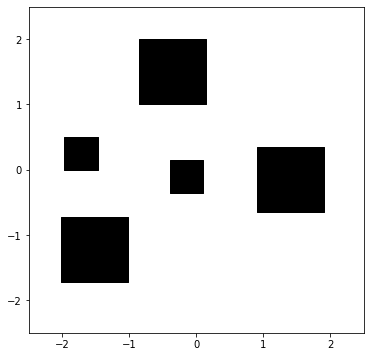

In [7]:
fig, ax = plt.subplots(figsize=(6,6))

obj_points_list = []
obj_plot_polys = []
for obj in scene_objects:
    
    errorCode, objHandl = sim.simxGetObjectHandle(client_id, obj, sim.simx_opmode_blocking)
    error_pos, objPos = sim.simxGetObjectPosition(client_id, objHandl, -1, sim.simx_opmode_streaming)
    error_ang, objAng = sim.simxGetObjectOrientation(client_id, objHandl, -1, sim.simx_opmode_streaming)
    
    objAng = list(reversed(objAng))
    
    points_local = get_bounding_box_corners_local_coordinates(client_id, objHandl)
     
    points_global = map_local_coordinates_to_global_coordinates(points_local, objAng, objPos)
    
    points_poly = [p[:2] for p in points_global]

    poly = np.array(points_poly)
    p = PlottablePoly(poly, facecolor = 'k')
    obj_plot_polys.append(p)
    obj_points_list.append(points_poly)

obj_points_list = np.array(obj_points_list)

p = PatchCollection(obj_plot_polys, color='k')

ax.add_collection(p)

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.show()
plt.close(fig)

In [8]:
line_x_coords = np.sort(obj_points_list[:,:,0].flatten())
line_x_coords = np.array([line_x_coords[i] for i in range(0,len(line_x_coords), 2)])
line_x_coords

array([-2.02499951, -1.97499979, -1.47499979, -1.02499951, -0.85123015,
       -0.3999995 ,  0.1000005 ,  0.14876985,  0.89999997,  1.89999997])

In [9]:
obj_poly_list = []
for obj_ps in obj_points_list:
    p1, p2, p3, p4 = map(Point, obj_ps)
    poly = Polygon(p1, p2, p3, p4)
    obj_poly_list.append(poly)

lines_list = []
for x_coord in line_x_coords:   
    p1, p2 = map(Point, [(x_coord,2.5), (x_coord,-2.5)])
    line = Line(p1,p2)
    lines_list.append(line)

i = 1
lines_intersects = []
for line in lines_list:
    print(f'testing line {i}')
    j = 0
    y_intersects = []
    for poly in obj_poly_list:
        print(f'\ttesting poly {j}')
        intersects = poly.intersection(line)
        points = [p.evalf() for p in intersects]
        if len(points) == 1:
            poly_ys = [p.evalf()[1] for p in poly.vertices] #to float
            max_y = max(poly_ys)
            min_y = min(poly_ys)
            y_intersects.append(max_y)
            y_intersects.append(min_y)
        else:
            for p in points:
                y_intersects.append(p[1])
        
        print('\t', points)
        j += 1
    lines_intersects.append(y_intersects)
    i += 1

testing line 1
	testing poly 0
	 []
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-2.02499950658127, -0.724999562864129)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 2
	testing poly 0
	 [Point2D(-1.97499978949439, 0.500000363712869)]
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-1.97499978949439, -1.72499956256987), Point2D(-1.97499978949439, -0.724999562569873)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 3
	testing poly 0
	 [Point2D(-1.47499978949439, 3.74669712709089e-7), Point2D(-1.47499978949439, 0.500000374669712)]
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-1.47499978949439, -1.72499955962730), Point2D(-1.47499978949439, -0.724999559627301)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 4
	testing poly 0
	 []
	testing poly 1
	 []
	testing poly 2
	 [Point2D(-1.02499950658127, -1.72499955697898), Point2D(-1.02499950658127, -0.724999556978985)]
	testing poly 3
	 []
	testing poly 4
	 []
testing line 5
	testing poly 0
	 []
	testing poly 1
	 [P

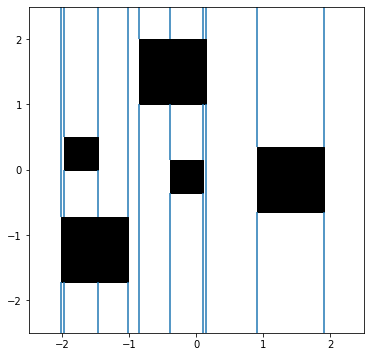

In [10]:
lines_intersects = [sorted(i) for i in lines_intersects]

fig, ax = plt.subplots(figsize=(6,6))

p = PatchCollection(obj_plot_polys, color='k')

ax.add_collection(p)

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])

for x, ys in zip(line_x_coords, lines_intersects):
    y_min = -2.5
    for i in range(0, len(ys)-1, 2):
        plt.vlines(x, y_min, float(ys[i]))
        y_min = float(ys[i+1])
    plt.vlines(x, y_min, 2.5)

plt.show()